# Лабораторная работа №4
## Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности
### Вариант 19
*Задание.* Найти приближенное решение начально-краевой задачи для уравнения теплопроводности:

$$
\begin{equation}
  \begin{cases}
    \frac{\partial u}{dt}=k\frac{\partial^2u}{\partial x^2}+f(x,t),  a < x < b, 0 < t \le T \\
    u(a, t) = g_1(t), \frac{\partial u}{\partial t}(b,t) = g_2(t),  0 < t \le T,\\
    u(x, 0) = \varphi(x), a \le x \le b.
  \end{cases}
\end{equation}
$$

используя явную и неявную разностные схемы.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# initial data variant 19

a = 0
b = 1
k = 0.2
T = 0.2
phi = lambda x: 1 - x*x
g1 = lambda t: 1
g2 = lambda t: 0
f = lambda x, t: 0
h = 0.01
t = 0.5 * h * h / k

### Явная схема

Используем аппроксимацию производной:
$$
\frac{\partial u}{\partial x} =\frac{u(x_n, \tau_N) - u(x_{n-1}, \tau_N)}{h} 
$$
Тогда: 
$$
g_2(\tau_N)=\frac{u(x_n, \tau_N) - u(x_{n-1}, \tau_N)}{h} 
$$
И
$$
u(x_n, \tau_N)=u(x_{n-1}, \tau_N)+hg_2(\tau_N)
$$

In [11]:
NK = int((b - a) / h) + 1 
NT = int(T / t) + 1

def solve1():
    M = np.zeros(shape=(NT, NK))
    M[:, 0] = np.array([g1(i) for i in np.linspace(0, T, NT)])
    M[0, :] = np.array([phi(i) for i in np.linspace(a, b, NK)])
    
    for i in range(1, NT):
        for j in range(1, NK - 1):
            xj = a + j*h
            M[i][j] = k * M[i-1][j+1]*t/(h*h) + \
                      (1 - 2*k*t/(h*h)) * M[i-1][j] + \
                      k*M[i-1][j-1]*t/(h*h) + \
                      t*f(xj, i*t)
        M[i][-1] = M[i][-2] + h * g2(t * i)
    return M

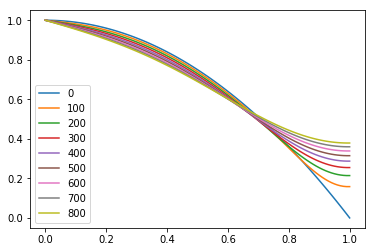

In [14]:
matrix = solve1()
X = np.linspace(a, b, NK)

for i in range(0, NT, 100):
    plt.plot(X, matrix[i], label=i)
plt.legend()
plt.show()

### Неявная схема